# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Loading the banana dataset from OpenML

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10, length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = sign.(y .- 0.5)

50-element Vector{Float64}:
 -1.0
  1.0
 -1.0
 -1.0
  1.0
  1.0
  1.0
 -1.0
  1.0
 -1.0
  ⋮
  1.0
  1.0
  1.0
  1.0
  1.0
 -1.0
 -1.0
  1.0
 -1.0

### We create a function to visualize the data

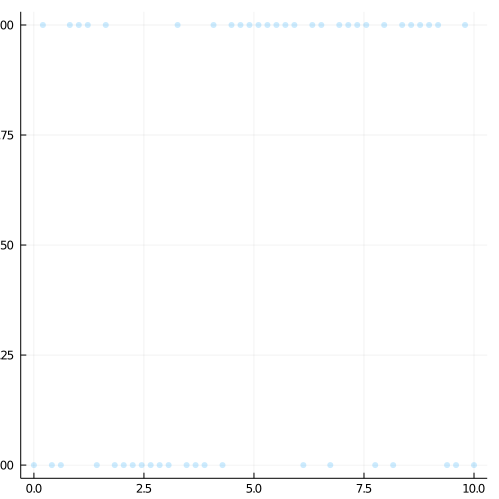

In [3]:
function plot_data(x, y; size=(300,500))
    Plots.scatter(x,
                y,
                alpha=0.2,
                markerstrokewidth=0.0,
                lab="",
                size=size
            )
end
plot_data(x, y; size = (500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign,
            kernel,
            LogisticLikelihood(),
            AnalyticVI(),
            optimiser = false
            )
@time train!(mfull, 5)

┌ Info: Running full model
└ @ Main.##384 string:1
  0.608220 seconds (1.15 M allocations: 66.693 MiB, 99.36% compilation time)


### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y,
            kernel,
            LogisticLikelihood(),
            GibbsSampling(),
            optimiser = false
            )
m = mmcmc
@time samples = sample(mmcmc, 1000)

┌ Info: Sampling from model
└ @ Main.##384 string:1
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:05:48
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:56
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:57
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:28
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:10
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:58
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:49
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:43
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:38
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:34
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:31
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:28
Sampling with Gi

1000-element Vector{Vector{Vector{Float64}}}:
 [[0.5182380098245558, 0.5578740167170726, 0.4688827885260291, 0.29370461256834707, 0.11420420173476953, -0.12040540262980301, -0.3036124681292686, -0.4655428000272692, -0.6220547358472627, -0.7343145813386515  …  1.0059915880893118, 1.1674322245749975, 1.2118789669217807, 1.1611055949614886, 1.014060108302049, 0.8143732135754469, 0.6292336039786072, 0.48427315900868617, 0.43515061596071947, 0.5035543541046539]]
 [[0.06956222544775686, -0.14154316962305322, -0.27938124616516113, -0.3696050746578293, -0.4149186036491274, -0.44407467412144436, -0.49555656219389205, -0.6068808131483215, -0.7824213954653085, -1.0546799095042527  …  0.5296038538305273, 0.49111590533916505, 0.5033881264668292, 0.49252030216378884, 0.49002501185993896, 0.4610292643809141, 0.43745603478099093, 0.37349405345994047, 0.31466534098921806, 0.19594646796546147]]
 [[-0.5991293172564613, -0.40558190297599606, -0.2861995020171833, -0.23334255700625264, -0.30933875379963927,

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

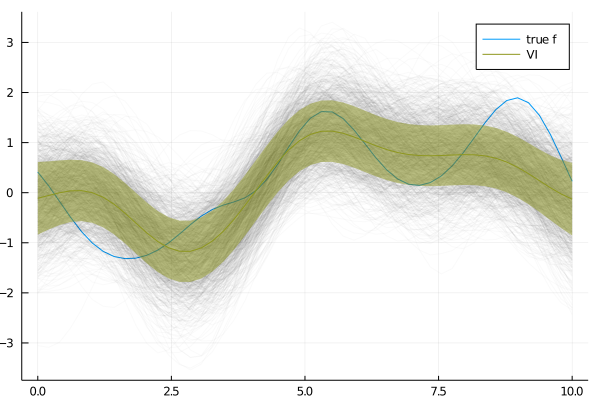

In [6]:
p1 = plot(x, f, label="true f")
plot!(x, samples, label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]), ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

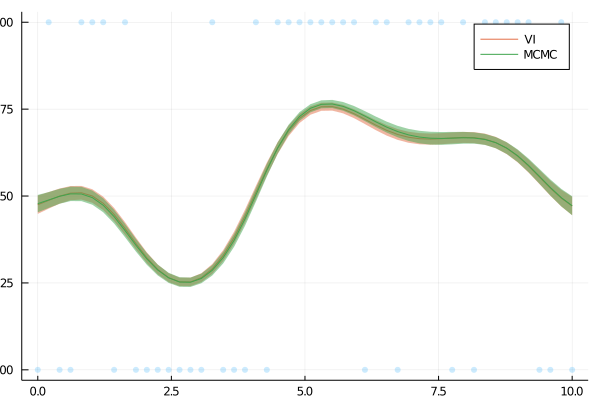

In [7]:
p2 = plot_data(x, y; size=(600,400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*